In [16]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [102]:
import numpy as np
import pandas as pd
import datetime as dt
from sqlalchemy import or_, and_

## Reflect Tables into SQLALchemy ORM

In [118]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [19]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [20]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [21]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [22]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [23]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [60]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
a = '2017-08-01'
b = '2017-08-07'
print(calc_temps(a,b))

[(72.0, 79.25, 83.0)]


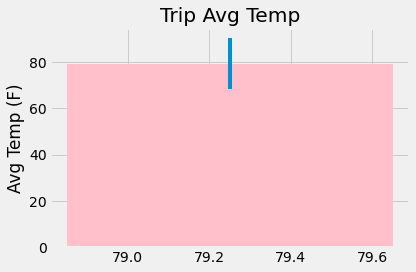

In [99]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmin= 72
tmax= 83
yavg= 79.25
plt.bar(yavg, yavg, color ='pink')
plt.errorbar(yavg,yavg,yerr=tmax-tmin)
plt.title('Trip Avg Temp')
plt.ylabel('Avg Temp (F)')
plt.tight_layout()
plt.show()

### Daily Rainfall Average

In [177]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

results = session.query(Measurement.date,Measurement.station,func.sum(Measurement.prcp),Station.name,Station.latitude,Station.longitude,Station.elevation).\
    filter(and_(Measurement.date>='2017-08-01',Measurement.date<='2017-08-07',Measurement.prcp!="None",Measurement.station==Station.station)).\
    group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()
list0 = [result[0] for result in results]
list1 = [result[1] for result in results]
list2 = [result[2] for result in results]
list3 = [result[3] for result in results]
list4 = [result[4] for result in results]
list5 = [result[5] for result in results]
list6 = [result[6] for result in results]
zipped = zip(list1,list2,list3,list4,list5,list6)
for item in zipped:
    print(item)

('USC00516128', 0.36, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
('USC00514830', 0.22, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
('USC00519397', 0.04, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
('USC00519523', 0.0, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
('USC00519281', 0.06, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)


### Daily Temperature Normals

In [164]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [173]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals =[]
# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'
# Use the start and end date to create a range of dates
trip_dates = ['2017-08-01','2017-08-02','2017-08-03','2017-08-04','2017-08-05','2017-08-06','2017-08-07']
# Strip off the year and save a list of strings in the format %m-%d
days=['08-01','08-02','08-03','08-04','08-05','08-06','08-07']
# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
for day in days:
  normals.append(daily_normals(day))
print(normals)

[[(67.0, 75.54, 83.0)], [(68.0, 75.60377358490567, 84.0)], [(70.0, 76.61111111111111, 85.0)], [(69.0, 76.71153846153847, 84.0)], [(69.0, 76.14814814814815, 82.0)], [(67.0, 76.25, 83.0)], [(71.0, 77.15686274509804, 83.0)]]


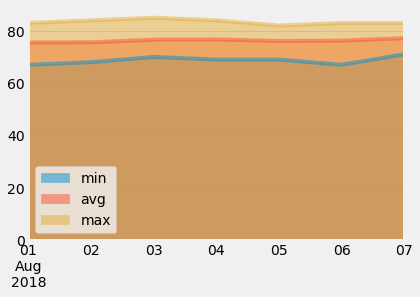

In [206]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame({
    'min': [67, 68, 70, 69, 69, 67, 71],
    'avg': [75.5, 75.6, 76.6, 76.7, 76.1, 76.25, 77.16],
    'max': [83, 84, 85, 84, 82, 83, 83],
}, index=pd.date_range(start='2018/08/01', end='2018/08/07',
                       freq='D'))
# Plot the daily normals as an area plot with `stacked=False`
ax = df.plot.area(stacked=False)

## Close Session

In [207]:
session.close()